In [107]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.float_format', lambda x: '%.2f' % x) # change decimal places

RSEED = 42

## Loading the processed dataframe (sugarbeet and field weatherstation data)

In [108]:
df = pd.read_pickle('data_strube/pickles/df_merge_weatherloc_dev_stage.pkl')
df

,betaine_nir,cry_nir,csy_nir,dm_nir,fieldid,region,invert_nir,mark_nir,ms_comp,obj,...,wind_direction_devstage_3,wind_speed_avg_devstage_1,wind_speed_avg_devstage_2,wind_speed_avg_devstage_3,wind_speed_gusts_devstage_1,wind_speed_gusts_devstage_2,wind_speed_gusts_devstage_3,wind_speed_max_devstage_1,wind_speed_max_devstage_2,wind_speed_max_devstage_3
0,0.16,54.60,8.84,21.54,Emmeloord,Niederlande,0.18,5.36,2,23,...,162.22,2.90,1.80,1.10,5.34,3.87,2.95,3.61,2.29,1.50
1,0.15,51.07,8.49,21.86,Emmeloord,Niederlande,0.15,5.22,6,3,...,162.22,2.90,1.80,1.10,5.34,3.87,2.95,3.61,2.29,1.50
2,0.14,52.73,8.36,21.19,Emmeloord,Niederlande,0.16,5.34,2,28,...,162.22,2.90,1.80,1.10,5.34,3.87,2.95,3.61,2.29,1.50
3,0.14,44.33,6.96,21.11,Emmeloord,Niederlande,0.16,5.42,1,33,...,162.22,2.90,1.80,1.10,5.34,3.87,2.95,3.61,2.29,1.50
4,0.13,50.00,7.84,20.85,Emmeloord,Niederlande,0.16,5.18,2,7,...,162.22,2.90,1.80,1.10,5.34,3.87,2.95,3.61,2.29,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649,0.11,67.87,11.72,22.74,Anklam,Norddeutschland,0.04,5.47,2,13,...,196.92,2.93,1.56,1.90,5.12,3.25,3.64,3.57,2.01,2.36
9650,0.08,74.47,12.50,21.72,Anklam,Norddeutschland,0.07,4.94,2,17,...,196.92,2.93,1.56,1.90,5.12,3.25,3.64,3.57,2.01,2.36
9651,0.08,70.93,12.18,22.10,Anklam,Norddeutschland,0.06,4.93,2,18,...,196.92,2.93,1.56,1.90,5.12,3.25,3.64,3.57,2.01,2.36
9652,0.09,71.13,12.30,22.22,Anklam,Norddeutschland,0.08,4.93,2,8,...,196.92,2.93,1.56,1.90,5.12,3.25,3.64,3.57,2.01,2.36


In [109]:
df.shape

(8768, 178)

In [110]:
# dropping columns 
df.drop(['betaine_nir', 
         'cry_nir', 
         'dm_nir', 
         'invert_nir', 
         'mark_nir', 
         #'csy_nir', 
         'totaln_nir',
         'fieldid', 
         'obj',  
         'seriesid', 
         'x', 
         'y', 
         'ms_comp',
         'otype_comp', 
         #'pollinator_comp',
         'region',
         'station_location',
         'sc_nir'
         ], axis=1, inplace=True)
df.columns

Index(['csy_nir', 'pollinator_comp', 'seednames_coded',
       'air_temperature_avg_devstage_1', 'air_temperature_avg_devstage_2',
       'air_temperature_avg_devstage_3', 'air_temperature_max_devstage_1',
       'air_temperature_max_devstage_2', 'air_temperature_max_devstage_3',
       'air_temperature_min_devstage_1',
       ...
       'wind_direction_devstage_3', 'wind_speed_avg_devstage_1',
       'wind_speed_avg_devstage_2', 'wind_speed_avg_devstage_3',
       'wind_speed_gusts_devstage_1', 'wind_speed_gusts_devstage_2',
       'wind_speed_gusts_devstage_3', 'wind_speed_max_devstage_1',
       'wind_speed_max_devstage_2', 'wind_speed_max_devstage_3'],
      dtype='object', length=162)

In [111]:
df.shape

(8768, 162)

In [112]:
# reset index after drpping columns
df = df.reset_index(drop=True)

#### Creating the pipeline

In [113]:
# creating list for numerical predictors/features
# since 'sc_nir' is our target variable we will exclude this feature from the list of numerical predictors 
# latitude and longitude are also excluded to avoid location influence on prediction
num_features = [
 'seednames_coded',
 'pollinator_comp',
 'air_temperature_avg_devstage_1',
 'air_temperature_avg_devstage_2',
 'air_temperature_avg_devstage_3',
 'air_temperature_max_devstage_1',
 'air_temperature_max_devstage_2',
 'air_temperature_max_devstage_3',
 'air_temperature_min_devstage_1',
 'air_temperature_min_devstage_2',
 'air_temperature_min_devstage_3',
 'deltat_avg_devstage_1',
 'deltat_avg_devstage_2',
 'deltat_avg_devstage_3',
 'deltat_max_devstage_1',
 'deltat_max_devstage_2',
 'deltat_max_devstage_3',
 'deltat_min_devstage_1',
 'deltat_min_devstage_2',
 'deltat_min_devstage_3',
 'dew_point_avg_devstage_1',
 'dew_point_avg_devstage_2',
 'dew_point_avg_devstage_3',
 'dew_point_min_devstage_1',
 'dew_point_min_devstage_2',
 'dew_point_min_devstage_3',
 'eag_soil_moisture_1_devstage_1',
 'eag_soil_moisture_1_devstage_2',
 'eag_soil_moisture_1_devstage_3',
 'eag_soil_moisture_2_devstage_1',
 'eag_soil_moisture_2_devstage_2',
 'eag_soil_moisture_2_devstage_3',
 'eag_soil_moisture_3_devstage_1',
 'eag_soil_moisture_3_devstage_2',
 'eag_soil_moisture_3_devstage_3',
 'eag_soil_moisture_4_devstage_1',
 'eag_soil_moisture_4_devstage_2',
 'eag_soil_moisture_4_devstage_3',
 'eag_soil_moisture_5_devstage_1',
 'eag_soil_moisture_5_devstage_2',
 'eag_soil_moisture_5_devstage_3',
 'eag_soil_moisture_6_devstage_1',
 'eag_soil_moisture_6_devstage_2',
 'eag_soil_moisture_6_devstage_3',
 'et0_devstage_1',
 'et0_devstage_2',
 'et0_devstage_3',
#  'latitude_1',
#  'latitude_2',
#  'latitude_3',
 'leaf_wetness_devstage_1',
 'leaf_wetness_devstage_2',
 'leaf_wetness_devstage_3',
#  'longitude_1',
#  'longitude_2',
#  'longitude_3',
 'precipitation_devstage_1',
 'precipitation_devstage_2',
 'precipitation_devstage_3',
 'relative_humidity_avg_devstage_1',
 'relative_humidity_avg_devstage_2',
 'relative_humidity_avg_devstage_3',
 'relative_humidity_max_devstage_1',
 'relative_humidity_max_devstage_2',
 'relative_humidity_max_devstage_3',
 'relative_humidity_min_devstage_1',
 'relative_humidity_min_devstage_2',
 'relative_humidity_min_devstage_3',
 'saturation_vpd_avg_devstage_1',
 'saturation_vpd_avg_devstage_2',
 'saturation_vpd_avg_devstage_3',
 'saturation_vpd_min_devstage_1',
 'saturation_vpd_min_devstage_2',
 'saturation_vpd_min_devstage_3',
 'soil_salinity_1_devstage_1',
 'soil_salinity_1_devstage_2',
 'soil_salinity_1_devstage_3',
 'soil_salinity_2_devstage_1',
 'soil_salinity_2_devstage_2',
 'soil_salinity_2_devstage_3',
 'soil_salinity_3_devstage_1',
 'soil_salinity_3_devstage_2',
 'soil_salinity_3_devstage_3',
 'soil_salinity_4_devstage_1',
 'soil_salinity_4_devstage_2',
 'soil_salinity_4_devstage_3',
 'soil_salinity_5_devstage_1',
 'soil_salinity_5_devstage_2',
 'soil_salinity_5_devstage_3',
 'soil_salinity_6_devstage_1',
 'soil_salinity_6_devstage_2',
 'soil_salinity_6_devstage_3',
 'soil_temperature_1_max_devstage_1',
 'soil_temperature_1_max_devstage_2',
 'soil_temperature_1_max_devstage_3',
 'soil_temperature_1_min_devstage_1',
 'soil_temperature_1_min_devstage_2',
 'soil_temperature_1_min_devstage_3',
 'soil_temperature_1_vg_devstage_1',
 'soil_temperature_1_vg_devstage_2',
 'soil_temperature_1_vg_devstage_3',
 'soil_temperature_2_max_devstage_1',
 'soil_temperature_2_max_devstage_2',
 'soil_temperature_2_max_devstage_3',
 'soil_temperature_2_min_devstage_1',
 'soil_temperature_2_min_devstage_2',
 'soil_temperature_2_min_devstage_3',
 'soil_temperature_2_vg_devstage_1',
 'soil_temperature_2_vg_devstage_2',
 'soil_temperature_2_vg_devstage_3',
 'soil_temperature_3_max_devstage_1',
 'soil_temperature_3_max_devstage_2',
 'soil_temperature_3_max_devstage_3',
 'soil_temperature_3_min_devstage_1',
 'soil_temperature_3_min_devstage_2',
 'soil_temperature_3_min_devstage_3',
 'soil_temperature_3_vg_devstage_1',
 'soil_temperature_3_vg_devstage_2',
 'soil_temperature_3_vg_devstage_3',
 'soil_temperature_4_max_devstage_1',
 'soil_temperature_4_max_devstage_2',
 'soil_temperature_4_max_devstage_3',
 'soil_temperature_4_min_devstage_1',
 'soil_temperature_4_min_devstage_2',
 'soil_temperature_4_min_devstage_3',
 'soil_temperature_4_vg_devstage_1',
 'soil_temperature_4_vg_devstage_2',
 'soil_temperature_4_vg_devstage_3',
 'soil_temperature_5_max_devstage_1',
 'soil_temperature_5_max_devstage_2',
 'soil_temperature_5_max_devstage_3',
 'soil_temperature_5_min_devstage_1',
 'soil_temperature_5_min_devstage_2',
 'soil_temperature_5_min_devstage_3',
 'soil_temperature_5_vg_devstage_1',
 'soil_temperature_5_vg_devstage_2',
 'soil_temperature_5_vg_devstage_3',
 'soil_temperature_6_max_devstage_1',
 'soil_temperature_6_max_devstage_2',
 'soil_temperature_6_max_devstage_3',
 'soil_temperature_6_min_devstage_1',
 'soil_temperature_6_min_devstage_2',
 'soil_temperature_6_min_devstage_3',
 'soil_temperature_6_vg_devstage_1',
 'soil_temperature_6_vg_devstage_2',
 'soil_temperature_6_vg_devstage_3',
 'solar_radiation_devstage_1',
 'solar_radiation_devstage_2',
 'solar_radiation_devstage_3',
 'wind_direction_devstage_1',
 'wind_direction_devstage_2',
 'wind_direction_devstage_3',
 'wind_speed_avg_devstage_1',
 'wind_speed_avg_devstage_2',
 'wind_speed_avg_devstage_3',
 'wind_speed_gusts_devstage_1',
 'wind_speed_gusts_devstage_2',
 'wind_speed_gusts_devstage_3',
 'wind_speed_max_devstage_1',
 'wind_speed_max_devstage_2',
 'wind_speed_max_devstage_3'
]
num_features

['seednames_coded',
 'pollinator_comp',
 'air_temperature_avg_devstage_1',
 'air_temperature_avg_devstage_2',
 'air_temperature_avg_devstage_3',
 'air_temperature_max_devstage_1',
 'air_temperature_max_devstage_2',
 'air_temperature_max_devstage_3',
 'air_temperature_min_devstage_1',
 'air_temperature_min_devstage_2',
 'air_temperature_min_devstage_3',
 'deltat_avg_devstage_1',
 'deltat_avg_devstage_2',
 'deltat_avg_devstage_3',
 'deltat_max_devstage_1',
 'deltat_max_devstage_2',
 'deltat_max_devstage_3',
 'deltat_min_devstage_1',
 'deltat_min_devstage_2',
 'deltat_min_devstage_3',
 'dew_point_avg_devstage_1',
 'dew_point_avg_devstage_2',
 'dew_point_avg_devstage_3',
 'dew_point_min_devstage_1',
 'dew_point_min_devstage_2',
 'dew_point_min_devstage_3',
 'eag_soil_moisture_1_devstage_1',
 'eag_soil_moisture_1_devstage_2',
 'eag_soil_moisture_1_devstage_3',
 'eag_soil_moisture_2_devstage_1',
 'eag_soil_moisture_2_devstage_2',
 'eag_soil_moisture_2_devstage_3',
 'eag_soil_moisture_3_devst

#### Train-Test-Split

In [114]:
# define predictors and target variable
X = df.drop('csy_nir', axis=1)
y = df['csy_nir']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 8768 observations in our dataset and 161 features
Our target vector has also 8768 values


In [115]:
# split into train and test set (train set: 70%, test set: 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED) 

In [116]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6137, 161)
X_test shape: (2631, 161)
y_train shape: (6137,)
y_test shape: (2631,)


#### Preprocessing Pipeline

In [117]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', RobustScaler())
])

In [118]:
# complete pipeline for numerical features
# apply transformers to numerical pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features)
])

### Predictive modeling using Pipeline and GridSearch

#### Random Forest

In [119]:
# building a full pipeline with our preprocessor and the RandomForestRegressor
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestRegressor())
])

In [120]:
# making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and number of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)

In [121]:
# Mean Squared Error
print('MSE Random Forest Train:\n', mean_squared_error(y_train, y_train_predicted))

# Root Mean Squared Error
print('RMSE Random Forest Train:\n', mean_squared_error(y_train, y_train_predicted, squared = False))

# R^2 Score
print('R^2 Random Forest Train:\n', r2_score(y_train, y_train_predicted))


MSE Random Forest Train:
 1.4258741907099508
RMSE Random Forest Train:
 1.1940997406874982
R^2 Random Forest Train:
 0.6545060361430083


#### Optimizing via GridSearch

In [122]:
# defining parameter space for grid-search
# add 'randomforest__' infront of the corresponding hyperparameters
param = {'randomforest__max_depth': [10,20,30,40,50],
                  'randomforest__max_features': ["sqrt"],
                  'randomforest__max_leaf_nodes': [500, 5000],
                  'randomforest__min_samples_split': [10, 50, 100]}

grid = GridSearchCV(pipe, param_grid=param, scoring = r2_score, cv=5,
                           verbose=1, n_jobs=-1)

In [123]:
# train the model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          RobustScaler())]),
                                                                         ['seednames_coded',
                                                                          'pollinator_comp',
                                                                          'air_temperature_avg_devstage_1',
                                                                          'air_temperature_avg_devstage_2',
                                                                          'air_temperature_avg_devstage_3',
                                                                          'air_temperature_max_devstage_1',
              

In [124]:
# show best parameters
print('Best score:\n{:.2f}'.format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best score:
nan
Best parameters:
{'randomforest__max_depth': 10, 'randomforest__max_features': 'sqrt', 'randomforest__max_leaf_nodes': 500, 'randomforest__min_samples_split': 10}


In [125]:
# save best model (including fitted preprocessing steps) as best_model 
best_model = grid.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   RobustScaler())]),
                                                  ['seednames_coded',
                                                   'pollinator_comp',
                                                   'air_temperature_avg_devstage_1',
                                                   'air_temperature_avg_devstage_2',
                                                   'air_temperature_avg_devstage_3',
                                                   'air_temperature_max_devstage_1',
                                                   'air_temperature_max_devstage_2',
                                                   'air_temperature_max_devstage...
                                                   'dew_point_avg_devstage_3',
               

In [126]:
# calculating the mean squared error, root mean squared error and r^2 score for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

# Mean Squared Error
print('MSE Random Forest Test:\n', mean_squared_error(y_test, y_test_predicted))

# Root Mean Squared Error
print('RMSE Random Forest Test:\n', mean_squared_error(y_test, y_test_predicted, squared = False))

# R^2 Score
print('R^2 Random Forest Test:\n', r2_score(y_test, y_test_predicted))

MSE Random Forest Test:
 1.0136439889609752
RMSE Random Forest Test:
 1.006798882081707
R^2 Random Forest Test:
 0.755289074686899


In [127]:
def error_analysis(y_test, y_pred):
    """Generated true vs. predicted values and residual scatter plot for models
    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """
    # calculate residuals
    residuals = y_test - y_pred
    # plot real vs. predicted values
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    ax[0].scatter(y_pred, y_test, color="blue", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred.min()-5), (y_pred.max()+5))
    ax[0].set_ylim((y_test.min()-10), (y_test.max()+10))
    ax[1].scatter(y_pred, residuals, color="blue", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred.min()-5), (y_pred.max()+5))
    ax[1].set_ylim((residuals.min()-5), (residuals.max()+5));

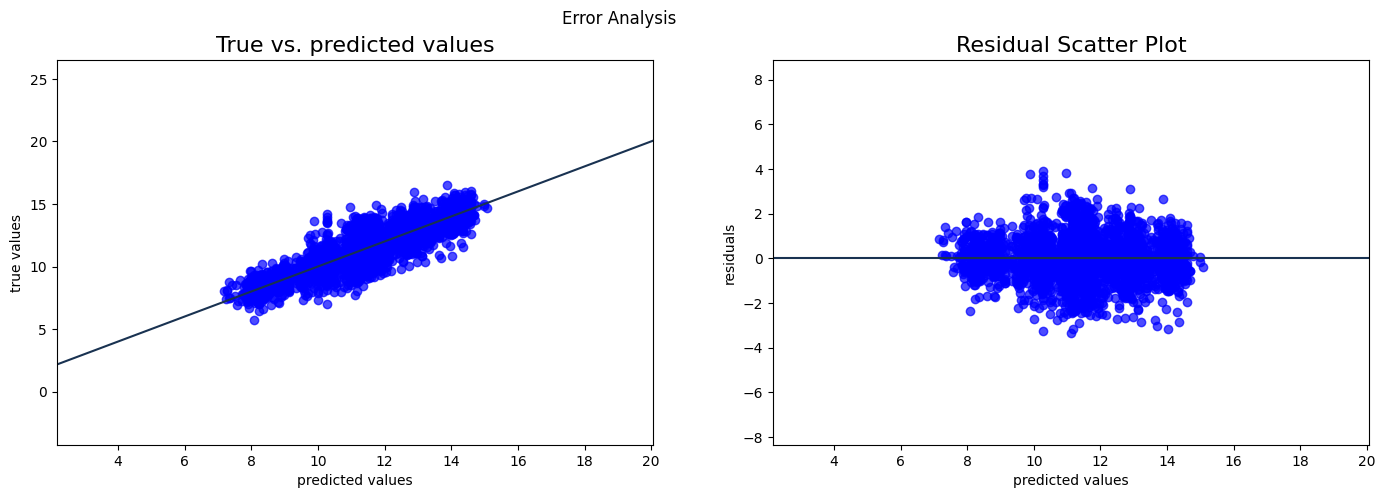

In [128]:
# evaluate the error
error_analysis(y_test,y_test_predicted)

#### Feature importance

In [129]:
# fit pipe with train data
model = pipe.fit(X_train, y_train)

In [130]:
# get coefficients
coefs = model.steps[1][1].feature_importances_

In [131]:
# get feature names
feature_names = model.steps[0][1].get_feature_names_out()

In [132]:
# zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "blue" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

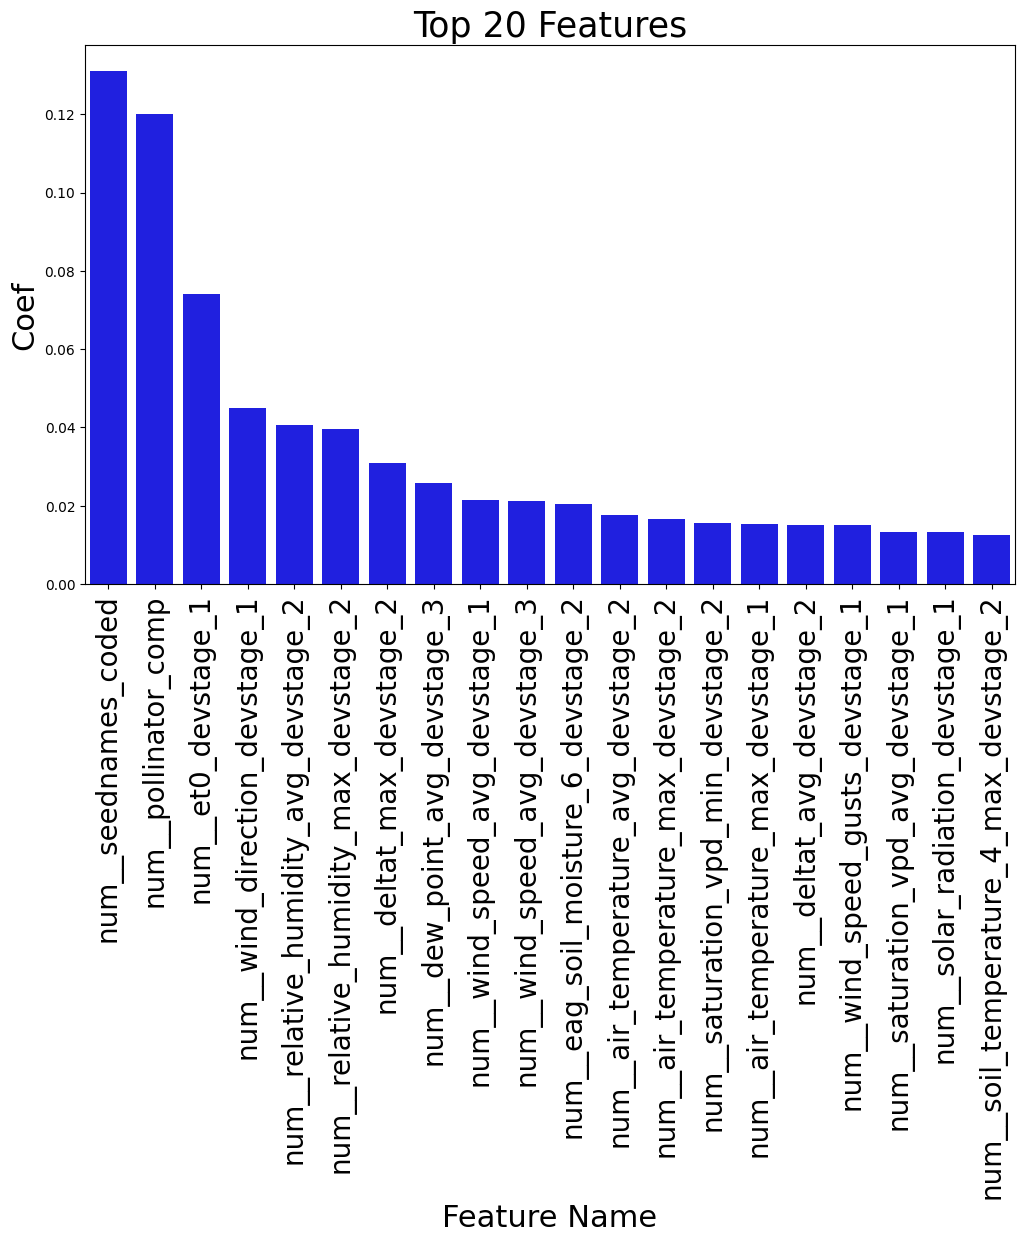

In [133]:
# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

## Loading the processed dataframe (sugarbeet and openweather weatherstation data)

In [134]:
df = pd.read_pickle('data_strube/pickles/df_merge_openweatherloc_dev_stage.pkl')
df

,betaine_nir,cry_nir,csy_nir,dm_nir,fieldid,region,invert_nir,mark_nir,ms_comp,obj,...,temp_max_dev_stage_3,temp_min_dev_stage_1,temp_min_dev_stage_2,temp_min_dev_stage_3,wind_deg_dev_stage_1,wind_deg_dev_stage_2,wind_deg_dev_stage_3,wind_speed_dev_stage_1,wind_speed_dev_stage_2,wind_speed_dev_stage_3
0,0.16,54.60,8.84,21.54,Emmeloord,Niederlande,0.18,5.36,2.00,23.00,...,13.27,8.27,15.90,10.73,191.66,198.40,214.08,3.62,2.10,3.23
1,0.15,51.07,8.49,21.86,Emmeloord,Niederlande,0.15,5.22,6.00,3.00,...,13.27,8.27,15.90,10.73,191.66,198.40,214.08,3.62,2.10,3.23
2,0.14,52.73,8.36,21.19,Emmeloord,Niederlande,0.16,5.34,2.00,28.00,...,13.27,8.27,15.90,10.73,191.66,198.40,214.08,3.62,2.10,3.23
3,0.14,44.33,6.96,21.11,Emmeloord,Niederlande,0.16,5.42,1.00,33.00,...,13.27,8.27,15.90,10.73,191.66,198.40,214.08,3.62,2.10,3.23
4,0.13,50.00,7.84,20.85,Emmeloord,Niederlande,0.16,5.18,2.00,7.00,...,13.27,8.27,15.90,10.73,191.66,198.40,214.08,3.62,2.10,3.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9649,0.11,67.87,11.72,22.74,Anklam,Norddeutschland,0.04,5.47,2.00,13.00,...,8.78,7.41,16.86,7.53,189.17,203.33,220.26,3.73,3.07,3.88
9650,0.08,74.47,12.50,21.72,Anklam,Norddeutschland,0.07,4.94,2.00,17.00,...,8.78,7.41,16.86,7.53,189.17,203.33,220.26,3.73,3.07,3.88
9651,0.08,70.93,12.18,22.10,Anklam,Norddeutschland,0.06,4.93,2.00,18.00,...,8.78,7.41,16.86,7.53,189.17,203.33,220.26,3.73,3.07,3.88
9652,0.09,71.13,12.30,22.22,Anklam,Norddeutschland,0.08,4.93,2.00,8.00,...,8.78,7.41,16.86,7.53,189.17,203.33,220.26,3.73,3.07,3.88


In [135]:
df.shape

(8768, 43)

In [136]:
# dropping columns 
df.drop(['betaine_nir', 
         'cry_nir', 
         'dm_nir', 
         'invert_nir', 
         'mark_nir', 
         'csy_nir', 
         'totaln_nir',
         'fieldid', 
         'obj',  
         'seriesid', 
         'x', 
         'y', 
         'ms_comp',
         'otype_comp', 
         'pollinator_comp',
         'region',
         'station_location'
         ], axis=1, inplace=True)
df.columns

Index(['sc_nir', 'seednames_coded', 'dew_point_dev_stage_1',
       'dew_point_dev_stage_2', 'dew_point_dev_stage_3',
       'humidity_dev_stage_1', 'humidity_dev_stage_2', 'humidity_dev_stage_3',
       'pressure_dev_stage_1', 'pressure_dev_stage_2', 'pressure_dev_stage_3',
       'temp_dev_stage_1', 'temp_dev_stage_2', 'temp_dev_stage_3',
       'temp_max_dev_stage_1', 'temp_max_dev_stage_2', 'temp_max_dev_stage_3',
       'temp_min_dev_stage_1', 'temp_min_dev_stage_2', 'temp_min_dev_stage_3',
       'wind_deg_dev_stage_1', 'wind_deg_dev_stage_2', 'wind_deg_dev_stage_3',
       'wind_speed_dev_stage_1', 'wind_speed_dev_stage_2',
       'wind_speed_dev_stage_3'],
      dtype='object')

In [137]:
df.shape

(8768, 26)

In [138]:
# reset index after drpping columns
df = df.reset_index(drop=True)

#### Creating the pipeline

In [139]:
# creating list for numerical predictors/features
# since 'sc_nir' is our target variable we will exclude this feature from the list of numerical predictors 
# latitude and longitude were previously excluded to avoid location influence on prediction
num_features = [
 'seednames_coded',
 'dew_point_dev_stage_1', 
 'dew_point_dev_stage_2',
 'dew_point_dev_stage_3', 
 'humidity_dev_stage_1', 
 'humidity_dev_stage_2',
 'humidity_dev_stage_3', 
 'pressure_dev_stage_1', 
 'pressure_dev_stage_2',
 'pressure_dev_stage_3', 
 'temp_dev_stage_1', 
 'temp_dev_stage_2',
 'temp_dev_stage_3', 
 'temp_max_dev_stage_1', 
 'temp_max_dev_stage_2',
 'temp_max_dev_stage_3', 
 'temp_min_dev_stage_1', 
 'temp_min_dev_stage_2',
 'temp_min_dev_stage_3', 
 'wind_deg_dev_stage_1', 
 'wind_deg_dev_stage_2',
 'wind_deg_dev_stage_3',
 'wind_speed_dev_stage_1',
 'wind_speed_dev_stage_2', 
 'wind_speed_dev_stage_3'
]
num_features

['seednames_coded',
 'dew_point_dev_stage_1',
 'dew_point_dev_stage_2',
 'dew_point_dev_stage_3',
 'humidity_dev_stage_1',
 'humidity_dev_stage_2',
 'humidity_dev_stage_3',
 'pressure_dev_stage_1',
 'pressure_dev_stage_2',
 'pressure_dev_stage_3',
 'temp_dev_stage_1',
 'temp_dev_stage_2',
 'temp_dev_stage_3',
 'temp_max_dev_stage_1',
 'temp_max_dev_stage_2',
 'temp_max_dev_stage_3',
 'temp_min_dev_stage_1',
 'temp_min_dev_stage_2',
 'temp_min_dev_stage_3',
 'wind_deg_dev_stage_1',
 'wind_deg_dev_stage_2',
 'wind_deg_dev_stage_3',
 'wind_speed_dev_stage_1',
 'wind_speed_dev_stage_2',
 'wind_speed_dev_stage_3']

#### Trian-Test-Split

In [140]:
# define predictors and target variable
X = df.drop('sc_nir', axis=1)
y = df['sc_nir']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 8768 observations in our dataset and 25 features
Our target vector has also 8768 values


In [141]:
# split into train and test set (train set: 70%, test set: 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED) 

In [142]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6137, 25)
X_test shape: (2631, 25)
y_train shape: (6137,)
y_test shape: (2631,)


#### Preprocessing Pipeline

In [143]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', RobustScaler())
])

In [144]:
# complete pipeline for numerical features
# apply transformers to numerical pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features)
])

### Predictive modeling using Pipeline and GridSearch

#### Random Forest

In [145]:
# building a full pipeline with our preprocessor and the RandomForestRegressor
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestRegressor())
])

In [146]:
# making predictions on the training set using cross validation as well as calculating the probabilities
# cross_val_predict expects an estimator (model), X, y and number of cv-splits (cv)
y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)

In [147]:
# Mean Squared Error
print('MSE Random Forest Train:\n', mean_squared_error(y_train, y_train_predicted))

# Root Mean Squared Error
print('RMSE Random Forest Train:\n', mean_squared_error(y_train, y_train_predicted, squared = False))

# R^2 Score
print('R^2 Random Forest Train:\n', r2_score(y_train, y_train_predicted))

MSE Random Forest Train:
 0.5792595404130447
RMSE Random Forest Train:
 0.7610910197952967
R^2 Random Forest Train:
 0.7987730962759573


#### Optimizing via GridSearch

In [148]:
# defining parameter space for grid-search
# add 'randomforest__' infront of the corresponding hyperparameters
param = {'randomforest__max_depth': [10,20,30,40,50],
                  'randomforest__max_features': ["sqrt"],
                  'randomforest__max_leaf_nodes': [500, 5000],
                  'randomforest__min_samples_split': [10, 50, 100]}

grid = GridSearchCV(pipe, param_grid=param, scoring = r2_score, cv=5,
                           verbose=1, n_jobs=-1)

In [149]:
# train the model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
TypeError: r2_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/isabellecarinaflaig/neuefische/capstone_project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          RobustScaler())]),
                                                                         ['seednames_coded',
                                                                          'dew_point_dev_stage_1',
                                                                          'dew_point_dev_stage_2',
                                                                          'dew_point_dev_stage_3',
                                                                          'humidity_dev_stage_1',
                                                                          'humidity_dev_stage_2',
                                              

In [150]:
# show best parameters
print('Best score:\n{:.2f}'.format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best score:
nan
Best parameters:
{'randomforest__max_depth': 10, 'randomforest__max_features': 'sqrt', 'randomforest__max_leaf_nodes': 500, 'randomforest__min_samples_split': 10}


In [151]:
# save best model (including fitted preprocessing steps) as best_model 
best_model = grid.best_estimator_
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   RobustScaler())]),
                                                  ['seednames_coded',
                                                   'dew_point_dev_stage_1',
                                                   'dew_point_dev_stage_2',
                                                   'dew_point_dev_stage_3',
                                                   'humidity_dev_stage_1',
                                                   'humidity_dev_stage_2',
                                                   'humidity_dev_stage_3',
                                                   'pressure_dev_stage_1',
                                                   'pressure_dev_stage_2',
                                                   'pressure_dev_stage

In [152]:
# calculating the mean squared error, root mean squared error and r^2 score for the test set with the optimized model
y_test_predicted = best_model.predict(X_test)

# Mean Squared Error
print('MSE Random Forest Test:\n', mean_squared_error(y_test, y_test_predicted))

# Root Mean Squared Error
print('RMSE Random Forest Test:\n', mean_squared_error(y_test, y_test_predicted, squared = False))

# R^2 Score
print('R^2 Random Forest Test:\n', r2_score(y_test, y_test_predicted))

MSE Random Forest Test:
 0.4208976277144439
RMSE Random Forest Test:
 0.6487662350295705
R^2 Random Forest Test:
 0.8568835162562395


In [153]:
def error_analysis(y_test, y_pred):
    """Generated true vs. predicted values and residual scatter plot for models
    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """
    # calculate residuals
    residuals = y_test - y_pred
    # plot real vs. predicted values
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    ax[0].scatter(y_pred, y_test, color="blue", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred.min()-5), (y_pred.max()+5))
    ax[0].set_ylim((y_test.min()-10), (y_test.max()+10))
    ax[1].scatter(y_pred, residuals, color="blue", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred.min()-5), (y_pred.max()+5))
    ax[1].set_ylim((residuals.min()-5), (residuals.max()+5));

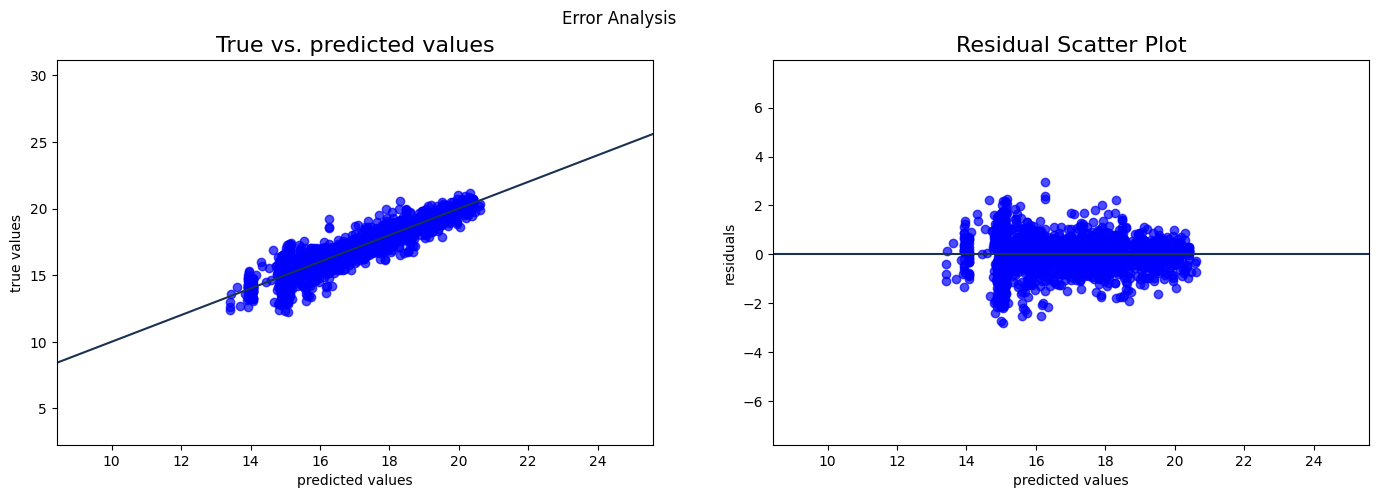

In [154]:
# evaluate the error
error_analysis(y_test,y_test_predicted)

#### Feature importance

In [155]:
# fit pipe with train data
model = pipe.fit(X_train, y_train)

In [156]:
# get coefficients
coefs = model.steps[1][1].feature_importances_

In [157]:
# get feature names
feature_names = model.steps[0][1].get_feature_names_out()

In [158]:
# zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "blue" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

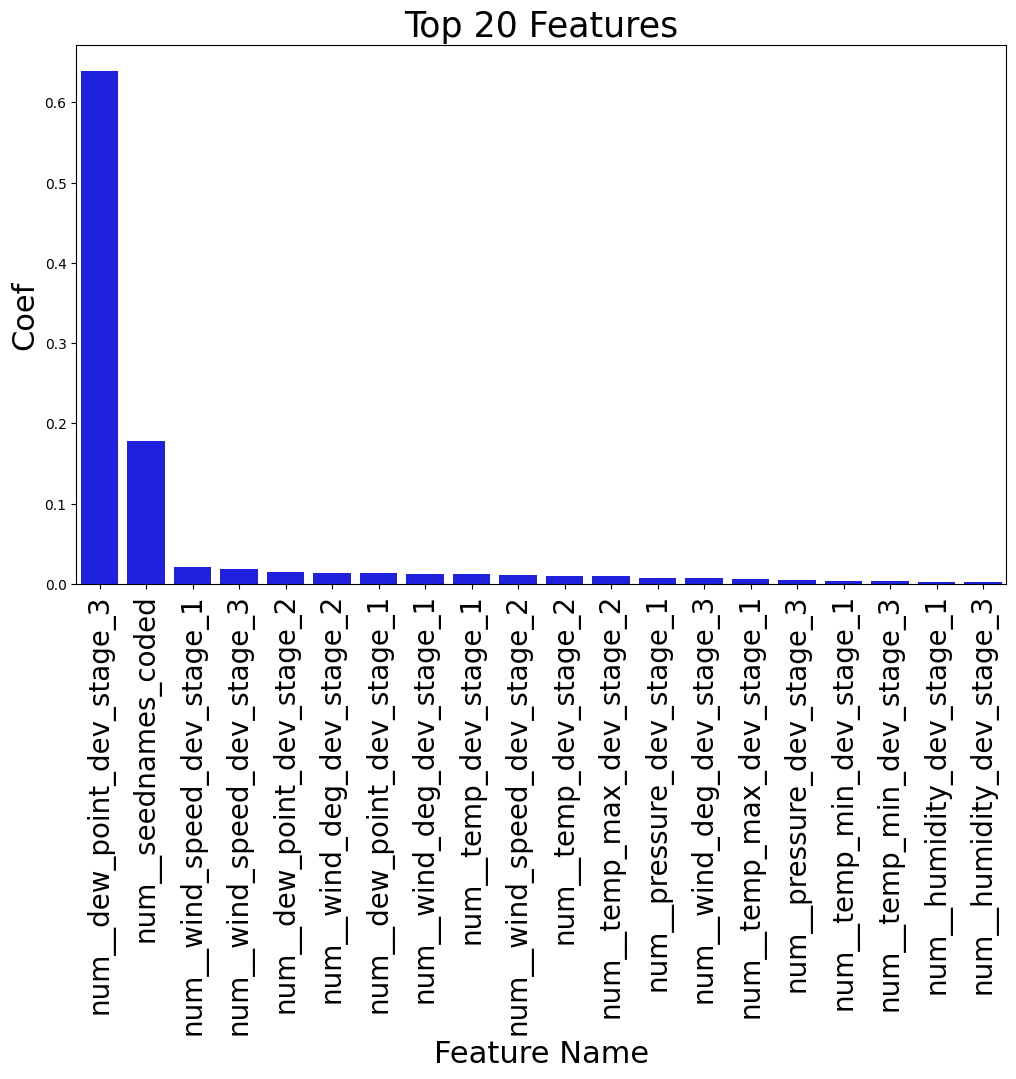

In [159]:
# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)